In [94]:
import copernicus_marine_client as copernicusmarine
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Download from copernicus

In [17]:
copernicusmarine.subset(
  dataset_id="cmems_mod_arc_bgc_my_ecosmo_P1M",
  variables=["model_depth", "no3", "o2", "po4", "si", "zooc", "phyc"],
  minimum_longitude=2.75,
  maximum_longitude=3,
  minimum_latitude=69.5,
  maximum_latitude=69.75,
  start_datetime="2018-01-01T00:00:00",
  end_datetime="2020-12-31T23:59:59",
  minimum_depth=0,
  maximum_depth=3000,
)

username:

  aberezina1


password:

  ········


INFO - 2023-12-12T15:57:00Z - Selected dataset version is "202105"
WARNING - 2023-12-12T15:57:01Z - Some or all of your subset selection [2018-01-01 00:00:00, 2020-12-31 23:59:59] for the time dimension  exceed the dataset coordinates [2007-01-01 00:00:00, 2020-12-01 00:00:00]
INFO - 2023-12-12T15:57:01Z - Downloading using service arco-time-series...
INFO - 2023-12-12T15:57:02Z - <xarray.Dataset>
Dimensions:      (depth: 38, latitude: 2, longitude: 2, time: 36)
Coordinates:
  * depth        (depth) float32 0.0 2.0 3.0 4.0 ... 902.0 1.062e+03 2e+03 3e+03
  * latitude     (latitude) float64 69.5 69.75
  * longitude    (longitude) float64 2.75 3.0
  * time         (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-12-01
Data variables:
    model_depth  (latitude, longitude) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    no3          (time, depth, latitude, longitude) float32 dask.array<chunksize=(34, 4, 2, 2), meta=np.ndarray>
    o2           (time, depth, latitude, longitu

C:\Users\ABE\AppData\Local\miniconda3\envs\Work\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


  Y


INFO - 2023-12-12T15:57:06Z - Writing to local storage. Please wait...


100%|███████████████████████████████████████████████████████████████████████████████| 605/605 [00:04<00:00, 126.34it/s]

INFO - 2023-12-12T15:57:11Z - Successfully downloaded to cmems_mod_arc_bgc_my_ecosmo_P1M_multi-vars_2.75E-3.00E_69.50N-69.75N_0.00-3000.00m_2018-01-01-2020-12-01.nc


WindowsPath('cmems_mod_arc_bgc_my_ecosmo_P1M_multi-vars_2.75E-3.00E_69.50N-69.75N_0.00-3000.00m_2018-01-01-2020-12-01.nc')

# Open forcing

In [72]:
phys = xr.open_dataset("../RT_brom3.nc")

In [73]:
z_phys = -phys['depth'].values

# Open copernicus DS

In [79]:
ds = (xr.open_dataset('cmems_monthly.nc')
      .mean(dim=['latitude', 'longitude'])
      .sel(time=slice('2019-01-01', '2020-01-01'))
      .interp(depth = z_phys)
     )

In [95]:
# dsmonth = ds.groupby("time.month").mean(dim="time")

In [97]:
ds

<xarray.Dataset>
Dimensions:      (time: 13, depth: 40)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2020-01-01
  * depth        (depth) float32 2.922 8.9 15.06 ... 2.552e+03 2.984e+03
Data variables:
    model_depth  float32 3.228e+03
    no3          (time, depth) float32 11.84 11.85 11.85 ... 15.29 15.27 15.25
    o2           (time, depth) float32 310.7 310.7 310.7 ... 297.1 297.0 296.9
    po4          (time, depth) float32 0.7976 0.7976 0.7977 ... 1.067 1.069
    si           (time, depth) float32 7.563 7.563 7.564 ... 11.42 11.6 11.8
    zooc         (time, depth) float32 0.006178 0.006178 ... 0.001526 0.001526
    phyc         (time, depth) float32 0.07478 0.07478 ... 0.01679 0.01679

# Plot variables

In [92]:
names = ['no3', 'o2', 'po4', 'si']

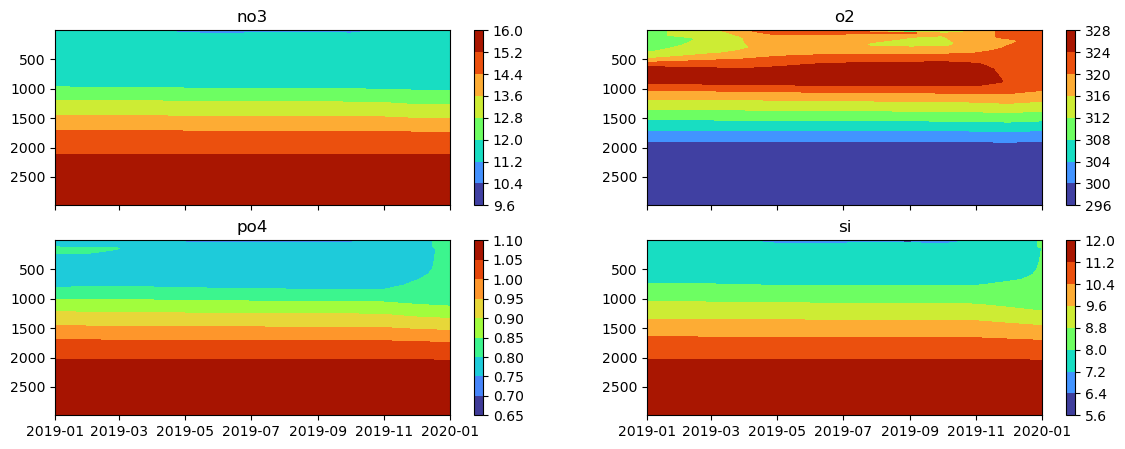

In [114]:
fig, axs = plt.subplots(2,2, figsize=(14,5), sharex=True)
for ax, name in zip(axs.ravel(), names):
    ax.invert_yaxis()
    cf = ax.contourf(ds.time, ds.depth, ds[name].T, cmap='turbo')
    ax.set_title(name)
    plt.colorbar(cf, ax=ax)
plt.savefig('relax.png', dpi=200, bbox_inches='tight')

# To DataFrame

In [84]:
df = (ds.resample(time='1D')
      .interpolate()
      .sel(time=slice('2019-01-01', '2019-12-31'))
      .to_dataframe(dim_order=['depth', 'time'])
      .reset_index())

In [85]:
df['JD'] = df['time'].dt.strftime('%j').astype(int)

# Output .dat

In [93]:
for name in names:
    df[['JD', 'depth', name]].to_csv('%s_RT.dat' % name,
                                      float_format='%.4f',
                                      header=False, index=False)